# Computer Vision > Read API

In [11]:
import os
import datetime
import time
import requests
from pprint import pprint
import json

# endpoint access configuration

# Config file wiht credentials structure:
# {
#     "computer-vision": {
#         "key": "abc",
#         "endpoint": "resource_endpoint"
#     }
# }

config_file = os.path.normpath(os.path.join(os.getcwd(), 'access_config.json'))
with open(config_file, 'r') as j:
     config = json.loads(j.read())
        
KEY = config['computer-vision']['key']
ENDPOINT = config['computer-vision']['endpoint']

API = {}
API['recognizetext'] = '/vision/v3.2/read/analyze' # recognize text # RETIRED vision/v2.0/recognizeText
API['recognizetext3.1'] = '/vision/v3.1/read/analyze' # recognize text # RETIRED vision/v2.0/recognizeText

In [12]:
def send_image(image_url, api_type, parameters):
    """ Submits data for processing by service
    Params:
        image_url (str): url for the image
        api_type (str): indicate which type of call should be
        parameters (dict): parameters for the request
    Returns:
        response (dict): data returned from api
    """
    success = False
    response = {}
    
    if api_type not in API.keys():
        print('ERROR: unsupported api type "%s" received.', api_type)
        return success, response
       
    # set request headers
    headers = {}
    headers['Ocp-Apim-Subscription-Key'] = KEY
    headers['content-type'] = 'application/json'
    
    # image read from file
    # headers['content-type'] = 'image/jpg'

    start_ts = datetime.datetime.now()
    
    # construct endpoint to call based on desired api
    url = ENDPOINT + API[api_type]
    print('\n%s URL: %s ' %(api_type.upper(), url))
    
    # contrsuct payload 
    payload = json.dumps({"url": image_url})
    
    # image from file
    #with open(filename, mode='rb') as file:
    #    payload = file.read()
    
    # send request    
    if parameters != {}:
        r = requests.post(url, data=payload, headers=headers, params=parameters)
    else:
        r = requests.post(url, data=payload, headers=headers)
    
    # process request
    if r.status_code in [200, 202]:
        print('INFO [%s]: data processed OK' %r.status_code)
    else:
        print('ERROR [%s]: %s, %r' %(r.status_code, r.text, r))
        return success, response 

    # result processing based on call
    if api_type == "recognizetext":
        operation_location = r.headers['Operation-Location']
        print('Operation Location: %s' %operation_location)
        
        # poll for the result
        success, response = get_response(operation_location)
        
        delta = datetime.datetime.now() - start_ts
        print ('\nINFO: time elapsed %s' %(delta))
        
        # print raw result
        print()
        pprint(response)

    print('Image processing completed.')
    return success, response
    
def get_response(operation_location):
    """ Get data processing results (for async invocation)
    Params:
        operation_location (str): operation location (endpoint + operationId)
    Returns:
        success (bool): flag indicating image processing result
        result (dict): extracted data from image, full API response
    """
    polling_interval = 1 # in seconds
    result = {}
    success = False
    
    print('INFO: GET processing results.')
    # set request headers
    headers = {}
    headers['Ocp-Apim-Subscription-Key'] = KEY
    
    # operation location is endpoint + operation ID
    
    # https://computervision-17feb2021.cognitiveservices.azure.com/vision/v3.2-preview.3/read/analyzeResults/8cc497b1-452d-4511-933c-402d66f01570
    operation_id = operation_location.split('/')[-1]
    operation_location = 'https://computervision-17feb2021.cognitiveservices.azure.com/vision/v3.2/read/analyzeResults/'+operation_id
    
    r = requests.get(operation_location, headers=headers)
    
    if r.status_code != 200:
        print('ERROR GET [%s]: %s, %r' %(r.status_code, r.text, r)) 
        return success, result
    else:
        # poll for the results
        while r.json()['status'] in ["running", "notStarted"]:
            # statuses include "failed" & "succeeded"
            time.sleep(polling_interval)
            r = requests.get(operation_location, headers=headers)
            print('\tINFO GET [%s]: %s: %s' %(r.status_code, r.json().get('status').upper(), r.json()))
            
        if r.json().get('status') == "succeeded":
            success = True
            result = r.json()
        else:
            print('FAILED GET: processing of the image')

    return success, result

In [13]:
# plot results
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image

import urllib

%matplotlib inline

def create_patch(rectangle):
    """ Create patch coordinates from Rectangle returned by CV API
    Parameters:
        rectangle(dict): height, width, x,y coordinates
            {'height': 393, 'left': 350,'top': 403,'width': 393} # FaceRectangle
            {'h': 881, 'w': 1063, 'x': 83, 'y': 26} # objects rectange
            [135, 191, 815, 336, 795, 567, 137, 528] list of coordinates from bounding box
    Returns:
        patch (list): list of points of patch as tuple (x,y)
                    [(83, 26), (1146, 26), (1146, 907), (83, 907)]
    """
    patch = []
  
    # transform input
    
    if isinstance(rectangle, dict):
        keys_map = {'height':'h', 'width': 'w', 'left': 'x', 'top':'y'}
        
        if 'height' in rectangle.keys():
            rectangle_new = {}
            for k in rectangle.keys():
                rectangle_new[keys_map[k]] = rectangle[k]
            rectangle = rectangle_new
            
        # construct points x,y - lower right point
        point_1 = (rectangle['x'], rectangle['y'])
        point_2 = (rectangle['x'] + rectangle['w'], rectangle['y'])
        point_3 = (rectangle['x'] + rectangle['w'], rectangle['y'] + rectangle['h'])
        point_4 = (rectangle['x'], rectangle['y'] + rectangle['h'])
        
        patch = [point_1, point_2, point_3, point_4]  
        
    elif isinstance(rectangle, list):
        #bounding box coordinates returned
        patch = [(rectangle[i*2], rectangle[i*2+1]) for i in range(int(len(rectangle)/2))]

    return patch
 
def plot_result(image_url, result):

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,10))
    #img = Image.open(filepath) # read image from file
    
    # from URL
    f = urllib.request.urlopen(image_url)
    img = Image.open(f)
    ax.imshow(img)    

    # add bounding boxes for objects found in image
    if result.get('analyzeResult').get('readResults'):
        
        for page in result.get('analyzeResult').get('readResults'):
            if page.get('lines'):
                
                # plot bounding box for line
                for line in page.get('lines'):
                    #print('LINE: %s' %line.get('text')) #v3.1
                    print('LINE: %s \t|%s' %(line.get('text'), line.get('appearance').get('style'))) #v3.2 
                    
                    bb = line.get('boundingBox') # example [135, 191, 815, 336, 795, 567, 137, 528]
                    rec = create_patch(bb)
                    ax.add_patch(mpatches.Polygon(rec, fill=False, color='blue'))
                    
                    if line.get('words'):
            
                        # plot bounding box for word
                        for word in line.get('words'):
                            bb = word.get('boundingBox')
                            rec = create_patch(bb)
                            ax.add_patch(mpatches.Polygon(rec, fill=False, color='pink'))
    
    plt.axis('off')
    plt.show()

In [14]:
parameters = {}
parameters['language'] = "en" # optional parameter

#image_url = 'https://th.bing.com/th/id/R25e74bf33c19135e88b8a2e1e43a5dd3?rik=6nC3Pouv2tYRRw&riu=http%3a%2f%2foffice-watch.com%2ffredagg%2fuploads%2fmaking-handwritten-letters-with-word-6846.png&ehk=aoGyDJmWMsLRyzABIdoqh8iDXUFxJx0nGHlUvao5Wcc%3d&risl=&pid=ImgRaw'

# image_url = 'https://i.ytimg.com/vi/TITKCfRX-Lg/maxresdefault.jpg'
# image_url = 'https://www.theandroidsoul.com/wp-content/uploads/2019/12/add-text-on-photo.png'

# page from a book
image_url = 'https://s-media-cache-ak0.pinimg.com/564x/e4/b9/6d/e4b96dcc5e324572a52195c5b9a71395.jpg' 

# similar to handwritten text wiht multiple angles
image_url = 'https://i.pinimg.com/736x/e0/c0/05/e0c005eb2f5e638f5d576d116c7e1c70.jpg' 

# handwriting
# image_url = 'https://th.bing.com/th/id/Rc19fbbcfb6c44fdd90ed3fbedaf31eb3?rik=MsYc5FTxlkWwPQ&riu=http%3a%2f%2ftimmilesandco.com%2fwp-content%2fuploads%2f2014%2f09%2fchalkboard_quotes_twain.jpg&ehk=edchHV%2bJh11CCeXVs%2fTWDBvhTE76DaxUErsqfB8TPHU%3d&risl=&pid=ImgRaw'

success, result = send_image(image_url, "recognizetext", {})



RECOGNIZETEXT URL: https://computervision-17feb2021.cognitiveservices.azure.com/vision/v3.2/read/analyze 
INFO [202]: data processed OK
Operation Location: https://computervision-17feb2021.cognitiveservices.azure.com/vision/v3.2-preview.3/read/analyzeResults/32e0c979-75a5-4701-ae3d-84399de5f4bd
INFO: GET processing results.
	INFO GET [200]: RUNNING: {'status': 'running', 'createdDateTime': '2021-03-22T10:18:18Z', 'lastUpdatedDateTime': '2021-03-22T10:18:18Z'}
	INFO GET [200]: SUCCEEDED: {'status': 'succeeded', 'createdDateTime': '2021-03-22T10:18:18Z', 'lastUpdatedDateTime': '2021-03-22T10:18:18Z', 'analyzeResult': {'version': '3.2.0', 'model-version': '2021-04-12', 'readResults': [{'page': 1, 'angle': -1.631, 'width': 735, 'height': 952, 'unit': 'pixel', 'lines': [{'boundingBox': [349, 85, 531, 102, 517, 172, 342, 155], 'text': 'Taylee (row', 'appearance': {'style': {'name': 'handwriting', 'confidence': 0.969}}, 'words': [{'boundingBox': [348, 85, 427, 92, 420, 163, 342, 155], 'text'

                                                          'text': 'Brock'},
                                                         {'boundingBox': [275,
                                                                          197,
                                                                          294,
                                                                          197,
                                                                          297,
                                                                          249,
                                                                          277,
                                                                          249],
                                                          'confidence': 0.982,
                                                          'text': '&'},
                                                         {'boundingBox': [303,
                                                             

                                                                          529],
                                                          'confidence': 0.796,
                                                          'text': 'nathan'},
                                                         {'boundingBox': [359,
                                                                          471,
                                                                          499,
                                                                          469,
                                                                          504,
                                                                          523,
                                                                          365,
                                                                          524],
                                                          'confidence': 0.877,
                                                    

LINE: Taylee (row 	|{'name': 'handwriting', 'confidence': 0.969}
LINE: Reagan 	|{'name': 'handwriting', 'confidence': 0.676}
LINE: Payton 	|{'name': 'other', 'confidence': 1}
LINE: Quade 	|{'name': 'handwriting', 'confidence': 0.991}
LINE: Brock & Jill Davin & Kara 	|{'name': 'handwriting', 'confidence': 0.948}
LINE: Kirk & Jenny 	|{'name': 'other', 'confidence': 1}
LINE: Whitney Bennett Lincoln 	|{'name': 'other', 'confidence': 1}
LINE: Jedrek 	|{'name': 'other', 'confidence': 1}
LINE: Susan 	|{'name': 'other', 'confidence': 1}
LINE: Travis & Margie 	|{'name': 'other', 'confidence': 1}
LINE: Trenna 	|{'name': 'handwriting', 'confidence': 0.969}
LINE: Kyanna Chandler Macie Caroline a Wife 	|{'name': 'other', 'confidence': 1}
LINE: Trish & nathan Christopher & Brooklyn 	|{'name': 'other', 'confidence': 1}
LINE: Addison & 	|{'name': 'other', 'confidence': 1}
LINE: Haven 	|{'name': 'other', 'confidence': 1}
LINE: Peterson 	|{'name': 'handwriting', 'confidence': 0.909}
LINE: Lavar Gene 	|{

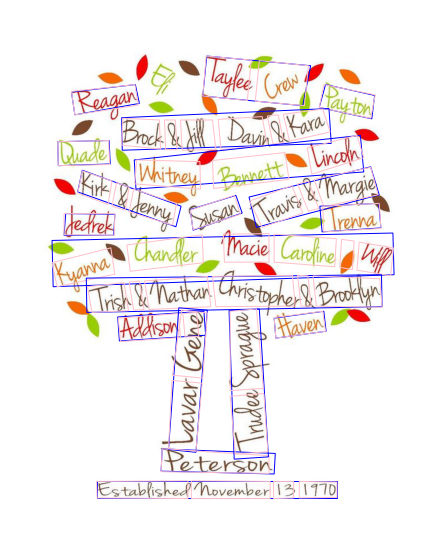

In [15]:
# Plot image & print text found by line
if success:
    plot_result(image_url, result)